### Import Modules

In [2]:
# To plot learning curve graph
%matplotlib inline
import matplotlib.pyplot as plt

# for pretty print
from pprint import pprint

# for tokenizer
import re

# for word counter in vocabulary dictionary
from collections import Counter

# TensorFlow of Course :)
import tensorflow as tf

# The paths of RNNCell or rnn functions are too long.
from tensorflow.contrib.legacy_seq2seq.python.ops import *

### Sample training data

In [3]:
enc_sentence_length = 10
dec_sentence_length = 10
batch_size = 4

In [4]:
input_batches = [
    ['Hi What is your name?', 'Nice to meet you!'],
    ['Which programming language do you use?', 'See you later.'],
    ['Where do you live?', 'What is your major?'],
    ['What do you want to drink?', 'What is your favorite beer?']]

target_batches = [
    ['Hi this is Jaemin.', 'Nice to meet you too!'],
    ['I like Python.', 'Bye Bye.'],
    ['I live in Seoul, South Korea.', 'I study industrial engineering.'],
    ['Beer please!', 'Leffe brown!']]

In [5]:
all_input_sentences = []
for input_batch in input_batches:
    all_input_sentences.extend(input_batch)
    
all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)

# Example
all_input_sentences

['Hi What is your name?',
 'Nice to meet you!',
 'Which programming language do you use?',
 'See you later.',
 'Where do you live?',
 'What is your major?',
 'What do you want to drink?',
 'What is your favorite beer?']

### NLP helper functions

In [6]:
def tokenizer(sentence):
    tokens = re.findall(r"[\w]+|[^\s\w]", sentence)
    return tokens

# Example
tokenizer('Hello world?? "sdfs%@#%')

['Hello', 'world', '?', '?', '"', 'sdfs', '%', '@', '#', '%']

In [7]:
def build_vocab(sentences, is_target=False, max_vocab_size=None):
    word_counter = Counter()
    vocab = dict()
    reverse_vocab = dict()
    
    for sentence in sentences:
        tokens = tokenizer(sentence)
        word_counter.update(tokens)
        
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)
    
    if is_target:
        vocab['_GO'] = 0
        vocab['_PAD'] = 1
        vocab_idx = 2
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
    else:
        vocab['_PAD'] = 0
        vocab_idx = 1
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
            
    for key, value in vocab.items():
        reverse_vocab[value] = key
            
    return vocab, reverse_vocab, max_vocab_size

# Example
pprint(build_vocab(all_input_sentences))
print('\n')
pprint(build_vocab(all_target_sentences))

({'!': 25,
  '.': 14,
  '?': 1,
  'Hi': 22,
  'Nice': 16,
  'See': 23,
  'What': 3,
  'Where': 26,
  'Which': 17,
  '_PAD': 0,
  'beer': 18,
  'do': 5,
  'drink': 15,
  'favorite': 8,
  'is': 4,
  'language': 21,
  'later': 19,
  'live': 10,
  'major': 13,
  'meet': 11,
  'name': 9,
  'programming': 24,
  'to': 7,
  'use': 12,
  'want': 20,
  'you': 2,
  'your': 6},
 {0: '_PAD',
  1: '?',
  2: 'you',
  3: 'What',
  4: 'is',
  5: 'do',
  6: 'your',
  7: 'to',
  8: 'favorite',
  9: 'name',
  10: 'live',
  11: 'meet',
  12: 'use',
  13: 'major',
  14: '.',
  15: 'drink',
  16: 'Nice',
  17: 'Which',
  18: 'beer',
  19: 'later',
  20: 'want',
  21: 'language',
  22: 'Hi',
  23: 'See',
  24: 'programming',
  25: '!',
  26: 'Where'},
 26)


({'!': 3,
  ',': 21,
  '.': 1,
  'Beer': 13,
  'Bye': 4,
  'Hi': 22,
  'I': 2,
  'Jaemin': 23,
  'Korea': 15,
  'Leffe': 6,
  'Nice': 18,
  'Python': 27,
  'Seoul': 16,
  'South': 26,
  '_PAD': 0,
  'brown': 14,
  'engineering': 25,
  'in': 24,
  'industr

In [8]:
enc_vocab, enc_reverse_vocab, enc_vocab_size = build_vocab(all_input_sentences)
dec_vocab, dec_reverse_vocab, dec_vocab_size = build_vocab(all_target_sentences, is_target=True)

In [9]:
def token2idx(word, vocab):
    return vocab[word]

for token in tokenizer('Nice to meet you!'):
    print(token, token2idx(token, enc_vocab))

Nice 16
to 7
meet 11
you 2
! 25


In [10]:
def sent2idx(sent, vocab=enc_vocab, max_sentence_length=enc_sentence_length, is_target=False):
    tokens = tokenizer(sent)
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    if is_target:
        return [0] + [token2idx(token, vocab) for token in tokens] + [1] * pad_length
    else:
        return [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length

# Enc Example
print('Hi What is your name?')
print(sent2idx('Hi What is your name?'))

# Dec Example
print('Hi this is Jaemin.')
print(sent2idx('Hi this is Jaemin.', vocab=dec_vocab, max_sentence_length=dec_sentence_length, is_target=True))

Hi What is your name?
([22, 3, 4, 6, 9, 1, 0, 0, 0, 0], 6)
Hi this is Jaemin.
[0, 23, 20, 10, 24, 2, 1, 1, 1, 1, 1]


In [11]:
def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=dec_reverse_vocab):
    return " ".join([idx2token(idx, reverse_vocab) for idx in indices])

### Hyperparameters

In [12]:
n_epoch = 2000
n_enc_layer = 3
n_dec_layer = 3
hidden_size = 30

enc_emb_size = 30
dec_emb_size = 30

### Build Graph

In [14]:
tf.reset_default_graph()

enc_inputs = tf.placeholder(
    tf.int32,
    shape=[None, enc_sentence_length],
    name='input_sentences')

sequence_lengths = tf.placeholder(
    tf.int32,
    shape=[None],
    name='sentences_length')

dec_inputs = tf.placeholder(
    tf.int32,
    shape=[None, dec_sentence_length+1],
    name='output_sentences')

# batch major => time major
enc_inputs_t = tf.transpose(enc_inputs, perm=[1,0])
dec_inputs_t = tf.transpose(dec_inputs, perm=[1,0])

with tf.device('/cpu:0'):
    enc_Wemb = tf.get_variable('enc_word_emb',
        initializer=tf.random_uniform([enc_vocab_size+1, enc_emb_size]))
    dec_Wemb = tf.get_variable('dec_word_emb',
        initializer=tf.random_uniform([dec_vocab_size+2, dec_emb_size]))
    dec_out_W = tf.get_variable('dec_out_W',
        initializer=tf.random_uniform([hidden_size, dec_vocab_size+2]))
    dec_out_b = tf.get_variable('dec_out_b',
        initializer=tf.random_uniform([dec_vocab_size+2]))
    
with tf.variable_scope('encoder'):
    enc_emb_inputs = tf.nn.embedding_lookup(enc_Wemb, enc_inputs_t)
    
    # enc_emb_inputs:
    #     list(enc_sent_len) of tensor[batch_size x embedding_size]
    # Because `static_rnn` takes list inputs
    enc_emb_inputs = tf.unstack(enc_emb_inputs)
    
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
    
    # enc_sent_len x batch_size x embedding_size
    enc_outputs, enc_last_state = tf.contrib.rnn.static_rnn(
        cell=enc_cell,
        inputs=enc_emb_inputs,
        sequence_length=sequence_lengths,
        dtype=tf.float32)

dec_outputs = []
dec_predictions = []
with tf.variable_scope('decoder') as scope:
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
    
    for i in range(dec_sentence_length+1):
        if i == 0:
            input_ = tf.nn.embedding_lookup(dec_Wemb, dec_inputs_t[i])
            state = enc_last_state
        else:
            scope.reuse_variables()
            input_ = tf.nn.embedding_lookup(dec_Wemb, dec_prediction)
        
        # dec_output: batch_size x dec_vocab_size+2
        # state:      batch_size x hidden_size
        dec_output, state = dec_cell(input_, state)
        dec_output = tf.nn.xw_plus_b(dec_output, dec_out_W, dec_out_b)
        
        # dec_prediction: batch_size x 1
        dec_prediction = tf.argmax(dec_output, axis=1)
        
        dec_outputs.append(dec_output)
        dec_predictions.append(dec_prediction)

# predictions: [batch_size x dec_sentence_lengths+1]
predictions = tf.transpose(tf.stack(dec_predictions), [1,0])

# labels & logits: [dec_sentence_length+1 x batch_size x dec_vocab_size+2]
labels = tf.one_hot(dec_inputs_t, dec_vocab_size+2)
logits = tf.stack(dec_outputs)
        
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=labels, logits=logits))

# training_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
training_op = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss)

### Run Graph

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for epoch in range(n_epoch):
        
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_token_indices = []
            target_token_indices = []
            sentence_lengths = []
            
            for input_sent in input_batch:
                input_sent, sent_len = sent2idx(input_sent)
                input_token_indices.append(input_sent)
                sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                target_token_indices.append(
                    sent2idx(target_sent,
                             vocab=dec_vocab, max_sentence_length=dec_sentence_length, is_target=True))
            
            # Evaluate three operations in the graph
            # => predictions, loss, training_op(optimzier)
            batch_preds, batch_loss, _ = sess.run(
                [predictions, loss, training_op],
                feed_dict={
                    enc_inputs: input_token_indices,
                    sequence_lengths: sentence_lengths,
                    dec_inputs: target_token_indices
                })
            loss_history.append(batch_loss)
            epoch_loss += batch_loss
            all_preds.append(batch_preds)
            
        # Logging every 400 epochs
        if epoch % 400 == 0:
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                    print('\t', input_sent)
                    print('\t => ', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
                    print('\tCorrent answer:', target_sent)
            print('\tepoch loss: {:.2f}\n'.format(epoch_loss))

Epoch 0
	 Hi What is your name?
	 =>  brown live live live live live live live live live live
	Corrent answer: Hi this is Jaemin.
	 Nice to meet you!
	 =>  brown live live live live live live live live live live
	Corrent answer: Nice to meet you too!
	 Which programming language do you use?
	 =>  brown live live live live live live live live live live
	Corrent answer: I like Python.
	 See you later.
	 =>  brown live live live live live live live live live live
	Corrent answer: Bye Bye.
	 Where do you live?
	 =>  brown live live live live live live live live live live
	Corrent answer: I live in Seoul, South Korea.
	 What is your major?
	 =>  brown live live live live live live live live live live
	Corrent answer: I study industrial engineering.
	 What do you want to drink?
	 =>  brown live live live live live live live live live live
	Corrent answer: Beer please!
	 What is your favorite beer?
	 =>  brown live live live live live live live live live live
	Corrent answer: Leffe brown!
	ep

### Learning Curve

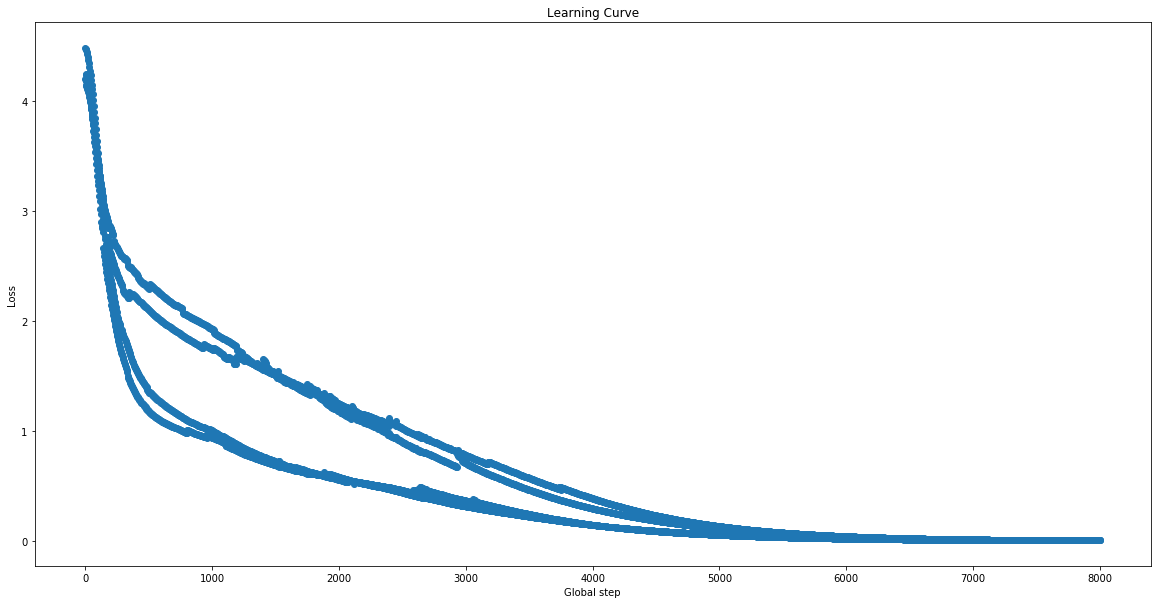

In [16]:
plt.figure(figsize=(20, 10))
plt.scatter(range(n_epoch * batch_size), loss_history)
plt.title('Learning Curve')
plt.xlabel('Global step')
plt.ylabel('Loss')
plt.show()